In [0]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
import pandas as pd
import os
import sys
from IPython.display import display, clear_output
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
pd.options.mode.chained_assignment = None

In [17]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13055201743350924070
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15961153617415132078
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15412139299286367840
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14912199066
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3122940245865166795
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
base_image_dir = os.path.join('drive/My Drive/Colab Notebooks', 'kaggle_data', 'train')
retina_df = pd.read_csv(os.path.join('drive/My Drive/Colab Notebooks', 'kaggle_data', 'trainLabels.csv'))
retina_df['PatientId'] = retina_df['image'].map(lambda x: x.split('_')[0])
retina_df['path'] = retina_df['image'].map(lambda x: os.path.join(base_image_dir,
                                                         '{}.jpeg'.format(x)))
retina_df['exists'] = retina_df['path'].map(os.path.exists)
print(retina_df['exists'].sum(), 'images found of', retina_df.shape[0], 'total')
retina_df['eye'] = retina_df['image'].map(lambda x: 1 if x.split('_')[-1]=='left' else 0)
from keras.utils.np_utils import to_categorical
retina_df['level_cat'] = retina_df['level'].map(lambda x: to_categorical(x, 1+retina_df['level'].max()))

retina_df.dropna(inplace = True)
retina_df = retina_df[retina_df['exists']]
retina_df.sample(3)

8407 images found of 35126 total


,image,level,PatientId,path,exists,eye,level_cat
9815,12382_right,0,12382,drive/My Drive/Colab Notebooks/kaggle_data/tra...,True,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
10071,12680_right,0,12680,drive/My Drive/Colab Notebooks/kaggle_data/tra...,True,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
14533,18218_right,0,18218,drive/My Drive/Colab Notebooks/kaggle_data/tra...,True,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"


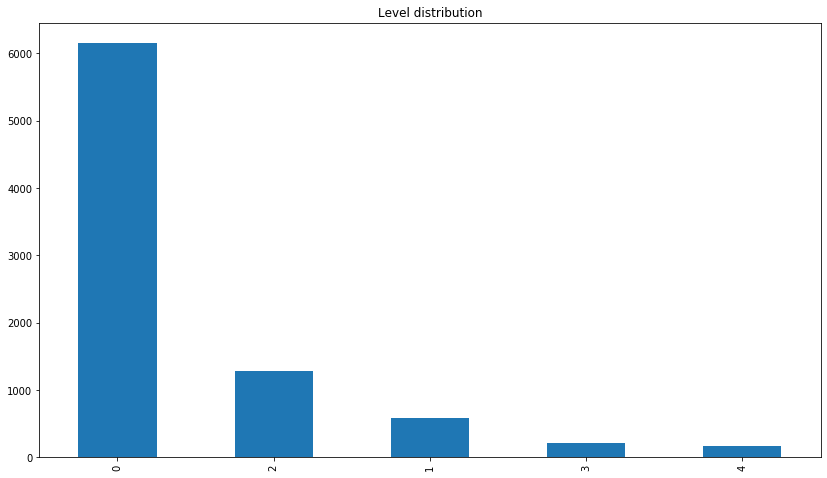

In [22]:
retina_df['level'].value_counts().plot(kind='bar', figsize=(14,8), title='Level distribution')

## Split Data into Training and Validation

In [4]:
from sklearn.model_selection import train_test_split
rr_df = retina_df[['PatientId', 'level']].drop_duplicates()
rr_df = rr_df.head(1000)
train_ids, test_ids = train_test_split(rr_df['PatientId'], 
                                   test_size = 0.25, 
                                   random_state = 2020,
                                   stratify = rr_df['level'])
train_df = retina_df[retina_df['PatientId'].isin(train_ids)]
test_df = retina_df[retina_df['PatientId'].isin(test_ids)]
print('train', train_df.shape[0], 'test', test_df.shape[0])

train 1349 test 486


### Creating Tensorflow Dataset

In [0]:
CLASS_NAMES = np.array(['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR'])
WIDTH, HEIGHT = 512, 512
BATCH_SIZE = 64

In [6]:
def createDataGen(df):
  datagen = tf.keras.preprocessing.image.ImageDataGenerator(
          rescale=1./255,
          shear_range=0.2,
          zoom_range=0.2,
          horizontal_flip=True)
  df['level'] = df['level'].astype(str)
  return datagen.flow_from_dataframe(df, x_col='path', y_col='level', target_size=(WIDTH,HEIGHT), 
                                     batch_size=BATCH_SIZE)
  
train_gen = createDataGen(train_df)
test_gen = createDataGen(test_df)

Found 1349 validated image filenames belonging to 5 classes.
Found 486 validated image filenames belonging to 5 classes.


In [0]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(5):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')        

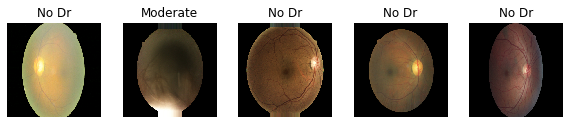

In [13]:
image_batch, label_batch = next(train_gen)
show_batch(image_batch, label_batch)

In [7]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation=layers.LeakyReLU(alpha=0.3), input_shape=(HEIGHT, WIDTH, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation=layers.LeakyReLU(alpha=0.3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation=layers.LeakyReLU(alpha=0.3)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation=layers.LeakyReLU(alpha=0.3)))
model.add(layers.Dense(len(CLASS_NAMES), activation='softmax'))
model.summary()
model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 510, 510, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 255, 255, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 253, 253, 64)      9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 126, 126, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 64)      36928     
_________________________________________________________________
flatten (Flatten)            (None, 984064)            0         
_________________________________________

In [10]:
model.fit_generator(train_gen, steps_per_epoch=int(train_df.shape[0] / BATCH_SIZE), epochs=5,
          validation_data=test_gen, validation_steps=int(test_df.shape[0] / BATCH_SIZE),
          use_multiprocessing=True)

Epoch 1/5
21/21 [==============================] - 629s 30s/step - loss: 14.2208 - acc: 0.4864 - val_loss: 4.0137 - val_acc: 0.1674
Epoch 2/5
21/21 [==============================] - 320s 15s/step - loss: 1.7043 - acc: 0.5751 - val_loss: 1.3307 - val_acc: 0.7009
Epoch 3/5
21/21 [==============================] - 327s 16s/step - loss: 1.1551 - acc: 0.6700 - val_loss: 1.0317 - val_acc: 0.6942
Epoch 4/5
21/21 [==============================] - 315s 15s/step - loss: 1.0608 - acc: 0.6825 - val_loss: 1.0450 - val_acc: 0.6674
Epoch 5/5
21/21 [==============================] - 323s 15s/step - loss: 0.9372 - acc: 0.7232 - val_loss: 0.9731 - val_acc: 0.6830


In [14]:
model.predict_classes(image_batch)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [15]:
label_batch

array([[1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1.